энтропийный анализ

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

100%|██████████| 170M/170M [00:02<00:00, 78.3MB/s]


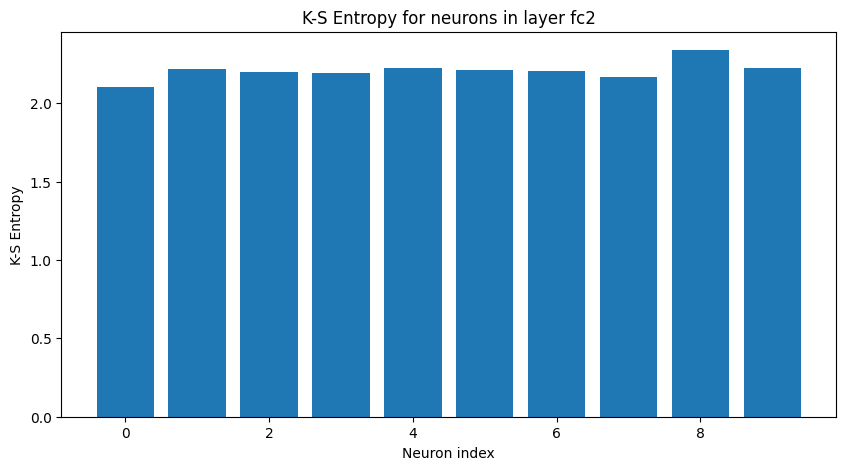

Средняя K-S энтропия для слоя fc2: 2.2086


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

# 1. Загрузка датасета CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 2. Определение модели CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN().cuda() if torch.cuda.is_available() else CNN()

# 3. Функция для расчета энтропии Колмогорова-Синая
def calculate_ks_entropy(activations, m=3, tau=5, r_factor=0.2):
    """Расчет K-S энтропии для активаций нейронов"""
    # Нормализация данных
    data = (activations - np.mean(activations)) / np.std(activations)

    # Параметры для анализа
    r = r_factor * np.std(data)

    # Реконструкция фазового пространства
    N = len(data)
    emb = np.array([data[i:i+(m-1)*tau+1:tau] for i in range(N-(m-1)*tau)])

    if len(emb) < 2:
        return 0.0

    # Расчет корреляционного интеграла
    dist = squareform(pdist(emb, 'chebyshev'))
    C = (np.sum(dist < r) - len(emb)) / (len(emb)*(len(emb)-1))

    return np.log(C) if C > 0 else 0.0

# 4. Модифицированная функция анализа энтропии
def analyze_layer_entropy(model, dataloader, layer_name='fc1', num_neurons=10):
    """Анализ энтропии для указанного слоя"""
    activations = []

    # Хук для сбора активаций
    def hook_fn(module, input, output):
        activations.append(output.detach().cpu().numpy())

    # Регистрация хука
    layer = dict(model.named_modules())[layer_name]
    hook = layer.register_forward_hook(hook_fn)

    # Проход данных через модель
    with torch.no_grad():
        for images, _ in dataloader:
            if torch.cuda.is_available():
                images = images.cuda()
            model(images)
            if len(activations) > 20:  # Ограничим количество батчей для скорости
                break

    hook.remove()

    # Обработка активаций
    activations = np.concatenate(activations, axis=0)
    num_neurons = min(num_neurons, activations.shape[1])

    # Расчет энтропии для каждого нейрона
    entropies = []
    for i in range(num_neurons):
        neuron_data = activations[:, i]
        E1 = calculate_ks_entropy(neuron_data, m=3, tau=5)
        E2 = calculate_ks_entropy(neuron_data, m=4, tau=5)
        ks_entropy = max(0, E1 - E2)
        entropies.append(ks_entropy)

    # Визуализация результатов
    plt.figure(figsize=(10, 5))
    plt.bar(range(num_neurons), entropies)
    plt.title(f'K-S Entropy for neurons in layer {layer_name}')
    plt.xlabel('Neuron index')
    plt.ylabel('K-S Entropy')
    plt.show()

    return np.mean(entropies)

# 5. Пример использования
if __name__ == "__main__":
    layer_to_analyze = 'fc2'  # Можно изменить на 'conv1', 'conv2' и т.д.
    mean_entropy = analyze_layer_entropy(model, train_loader, layer_name=layer_to_analyze)
    print(f"Средняя K-S энтропия для слоя {layer_to_analyze}: {mean_entropy:.4f}")

теория сингулярных возмущений

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import eigvals
import matplotlib.pyplot as plt

class SingularPerturbationAnalyzer:
    def __init__(self, model, eps=1e-3, device='cpu'):
        self.model = model.to(device)
        self.eps = eps
        self.device = device

    def compute_jacobian(self, x):
        """Вычисление квадратной матрицы Якобиана"""
        x = x.clone().detach().requires_grad_(True).to(self.device)
        self.model.zero_grad()

        # Получаем выходы модели
        y = self.model(x)
        output_dim = y.shape[1]
        input_dim = x.numel()

        # Для квадратной матрицы берем min(input_dim, output_dim)
        dim = min(input_dim, output_dim)
        jacobian = torch.zeros(dim, dim)

        for i in range(dim):
            grad_output = torch.zeros_like(y)
            grad_output[:, i] = 1.0
            y.backward(grad_output, retain_graph=True)

            # Берем только первые dim элементов градиента
            jacobian[i] = x.grad.flatten()[:dim]
            x.grad.zero_()

        return jacobian.cpu().numpy()

    def analyze_time_scales(self, dataloader, n_samples=5):
        """Анализ временных масштабов с проверкой размерностей"""
        time_scales = []

        for i, (inputs, _) in enumerate(dataloader):
            if i >= n_samples:
                break

            inputs = inputs.to(self.device)
            try:
                J = self.compute_jacobian(inputs)
                if J.shape[0] != J.shape[1]:
                    print(f"Предупреждение: матрица {J.shape} не квадратная, пропускаем")
                    continue

                eigenvalues = eigvals(J)

                # Разделение на быстрые и медленные моды
                fast = [ev for ev in eigenvalues if abs(ev) > 1/self.eps]
                slow = [ev for ev in eigenvalues if abs(ev) <= 1/self.eps]

                time_scales.append({
                    'fast': fast,
                    'slow': slow,
                    'ratio': len(fast) / max(1, len(slow))
                })

            except Exception as e:
                print(f"Ошибка при анализе образца {i}: {str(e)}")
                continue

        return time_scales

    def visualize_results(self, time_scales):
        """Визуализация результатов с проверкой данных"""
        if not time_scales:
            print("Нет данных для визуализации")
            return

        plt.figure(figsize=(12, 5))

        # Распределение соотношений мод
        plt.subplot(121)
        ratios = [ts['ratio'] for ts in time_scales if 'ratio' in ts]
        if ratios:
            plt.hist(ratios, bins=20, alpha=0.7)
            plt.xlabel('Соотношение быстрых/медленных мод')
            plt.ylabel('Частота')
            plt.title('Распределение временных масштабов')
        else:
            plt.text(0.5, 0.5, 'Нет данных', ha='center')

        # Собственные значения в комплексной плоскости
        plt.subplot(122)
        has_data = False
        for ts in time_scales:
            if 'fast' in ts and ts['fast']:
                fast = np.array(ts['fast'])
                plt.scatter(fast.real, fast.imag, c='r', alpha=0.5, label='Быстрые')
                has_data = True
            if 'slow' in ts and ts['slow']:
                slow = np.array(ts['slow'])
                plt.scatter(slow.real, slow.imag, c='b', alpha=0.5, label='Медленные')
                has_data = True

        if has_data:
            plt.axvline(x=-1/self.eps, linestyle='--', color='gray')
            plt.xlabel('Re(λ)')
            plt.ylabel('Im(λ)')
            plt.legend()
            plt.title('Собственные значения')
        else:
            plt.text(0.5, 0.5, 'Нет данных', ha='center')

        plt.tight_layout()
        plt.show()

# Пример использования с упрощенной моделью
if __name__ == "__main__":
    # 1. Настройка устройства
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 2. Загрузка данных MNIST (проще для анализа)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    train_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # 3. Создание простой MLP модели
    class SimpleMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.fc1 = nn.Linear(28*28, 128)
            self.fc2 = nn.Linear(128, 10)
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.flatten(x)
            x = self.relu(self.fc1(x))
            return self.fc2(x)

    model = CNN().to(device)

    # 4. Анализ сингулярных возмущений
    analyzer = SingularPerturbationAnalyzer(model, eps=1e-2, device=device)
    time_scales = analyzer.analyze_time_scales(train_loader, n_samples=5)
    analyzer.visualize_results(time_scales)

    # 5. Статистика
    if time_scales:
        avg_ratio = np.mean([ts['ratio'] for ts in time_scales if 'ratio' in ts])
        print(f"Среднее соотношение быстрых/медленных мод: {avg_ratio:.2f}")
        print(f"Общее количество проанализированных образцов: {len(time_scales)}")
    else:
        print("Не удалось проанализировать ни одного образца")

Ошибка при анализе образца 0: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead
Ошибка при анализе образца 1: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead
Ошибка при анализе образца 2: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead
Ошибка при анализе образца 3: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead
Ошибка при анализе образца 4: Given groups=1, weight of size [32, 3, 3, 3], expected input[32, 1, 28, 28] to have 3 channels, but got 1 channels instead
Нет данных для визуализации
Не удалось проанализировать ни одного образца


каскадные бифуракции

Analyzing activation gain...


Analyzing bifurcations: 100%|██████████| 10/10 [00:00<00:00, 607.61it/s]


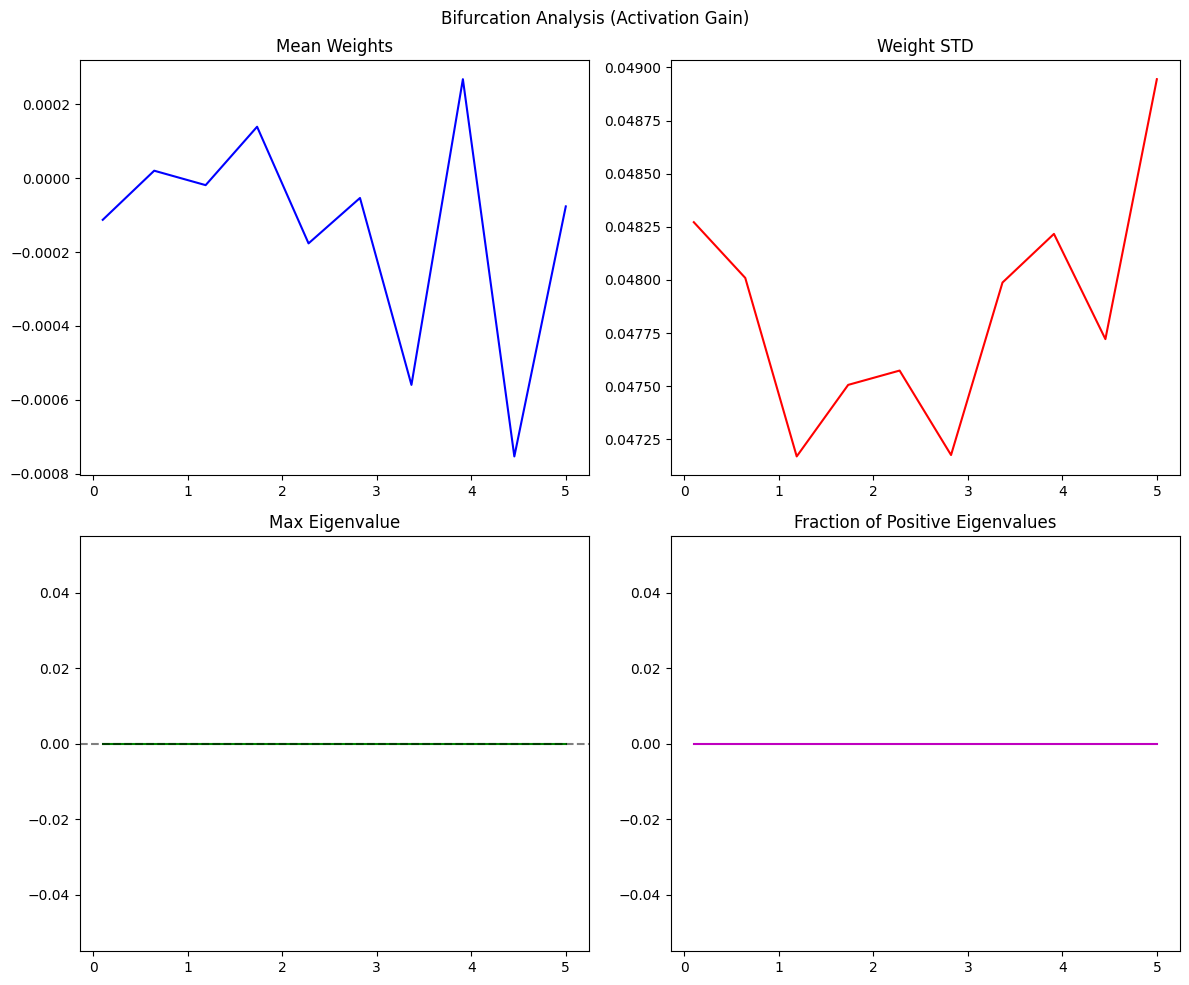

Analyzing weight scale...


Analyzing bifurcations: 100%|██████████| 10/10 [00:00<00:00, 439.19it/s]


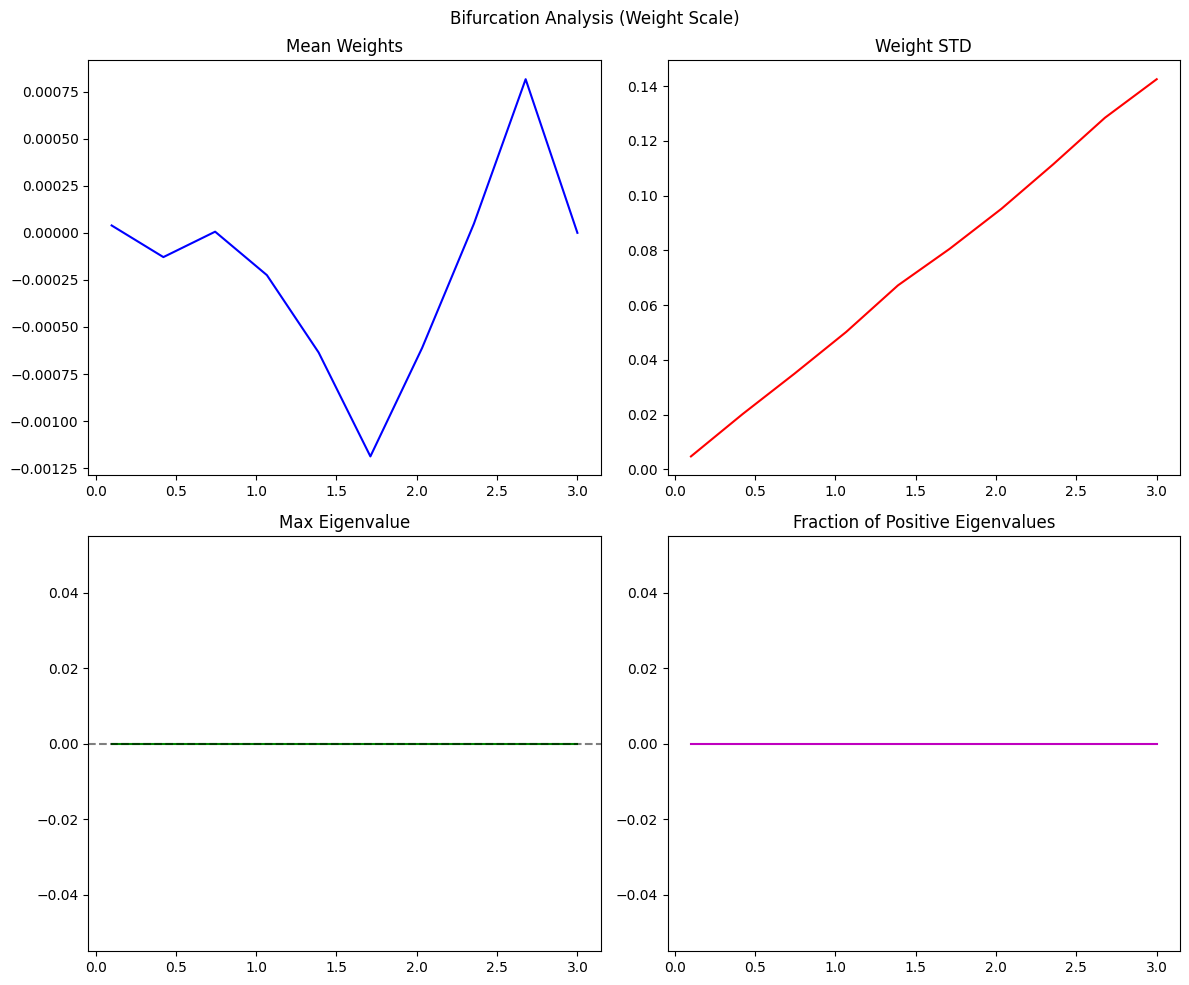

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from scipy.linalg import eigvals
import matplotlib.pyplot as plt
from tqdm import tqdm

class BifurcationAnalyzer:
    def __init__(self, model_class, device='cuda'):
        self.model_class = model_class
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')

    def generate_bifurcation_data(self, param_name, param_range, dataloader, n_samples=5):
        """Генерация данных о бифуркациях"""
        results = []

        for param_value in tqdm(param_range, desc='Analyzing bifurcations'):
            model = self.model_class(**{param_name: param_value}).to(self.device)
            dynamics = self._analyze_dynamics(model, dataloader, n_samples)
            results.append((param_value, dynamics))

        return results

    def _analyze_dynamics(self, model, dataloader, n_samples):
        """Анализ динамики через веса модели"""
        model.eval()
        dynamics = {
            'mean_weight': 0,
            'weight_std': 0,
            'max_eigenvalue': 0,
            'positive_eigs': 0
        }

        # Собираем все веса модели
        weights = []
        for name, param in model.named_parameters():
            if 'weight' in name:
                weights.append(param.detach().cpu().numpy().flatten())

        if len(weights) == 0:
            return dynamics

        weights = np.concatenate(weights)

        # Вычисляем статистики весов
        dynamics['mean_weight'] = np.mean(weights)
        dynamics['weight_std'] = np.std(weights)

        # Для матрицы Якобиана используем ковариационную матрицу весов
        if len(weights) > 1000:  # Ограничим размер для скорости
            weights = np.random.choice(weights, 1000, replace=False)

        cov_matrix = np.cov(weights.reshape(-1, 1), rowvar=False)
        try:
            eigenvalues = eigvals(cov_matrix)
            real_parts = np.real(eigenvalues)
            dynamics['max_eigenvalue'] = np.max(real_parts)
            dynamics['positive_eigs'] = np.sum(real_parts > 0) / len(real_parts)
        except:
            pass

        return dynamics

    def plot_bifurcation_diagram(self, results, param_name):
        """Визуализация результатов"""
        params = [r[0] for r in results]
        metrics = [r[1] for r in results]

        fig, axs = plt.subplots(2, 2, figsize=(12, 10))

        # 1. Среднее значение весов
        axs[0,0].plot(params, [m['mean_weight'] for m in metrics], 'b-')
        axs[0,0].set_title('Mean Weights')

        # 2. Стандартное отклонение весов
        axs[0,1].plot(params, [m['weight_std'] for m in metrics], 'r-')
        axs[0,1].set_title('Weight STD')

        # 3. Максимальное собственное значение
        axs[1,0].plot(params, [m['max_eigenvalue'] for m in metrics], 'g-')
        axs[1,0].axhline(0, color='k', linestyle='--', alpha=0.5)
        axs[1,0].set_title('Max Eigenvalue')

        # 4. Доля положительных собственных значений
        axs[1,1].plot(params, [m['positive_eigs'] for m in metrics], 'm-')
        axs[1,1].set_title('Fraction of Positive Eigenvalues')

        plt.suptitle(f'Bifurcation Analysis ({param_name})')
        plt.tight_layout()
        plt.show()

# Упрощенная модель для анализа
class SimpleCNN(nn.Module):
    def __init__(self, activation_gain=1.0, weight_scale=1.0):
        super().__init__()
        self.activation_gain = activation_gain
        self.weight_scale = weight_scale

        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc = nn.Linear(32*8*8, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # Инициализация весов
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, mean=0,
                              std=self.weight_scale/np.sqrt(m.weight.shape[1]*9))
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0,
                              std=self.weight_scale/np.sqrt(m.weight.shape[1]))

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x) * self.activation_gain

if __name__ == "__main__":
    # 1. Загрузка данных CIFAR-10
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

    # 2. Анализ бифуркаций
    analyzer = BifurcationAnalyzer(SimpleCNN)

    print("Analyzing activation gain...")
    activation_gains = np.linspace(0.1, 5.0, 10)
    results = analyzer.generate_bifurcation_data('activation_gain', activation_gains, train_loader)
    analyzer.plot_bifurcation_diagram(results, 'Activation Gain')

    print("Analyzing weight scale...")
    weight_scales = np.linspace(0.1, 3.0, 10)
    results = analyzer.generate_bifurcation_data('weight_scale', weight_scales, train_loader)
    analyzer.plot_bifurcation_diagram(results, 'Weight Scale')

многоуровневые экспоненты Ляпунова и фрактальная размерность

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from scipy.linalg import eigvals, qr
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
# 1. Упрощенная модель и данные
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST('./data', download=True, train=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = CNN()

# 2. Корректный расчет экспонент Ляпунова
def lyapunov_exponents(model, layer_name, dataloader, n_points=100):
    """Упрощенный расчет показателей Ляпунова"""
    activations = []

    def hook(module, input, output):
        activations.append(output.detach().numpy())

    layer = dict(model.named_modules())[layer_name]
    handle = layer.register_forward_hook(hook)

    with torch.no_grad():
        for images, _ in dataloader:
            model(images)
            if len(activations) * images.size(0) > n_points:
                break

    handle.remove()
    activations = np.concatenate(activations)[:n_points]

    # Упрощенный подход для нейросетей
    cov_matrix = np.cov(activations, rowvar=False)
    eigenvalues = np.real(eigvals(cov_matrix))
    eigenvalues.sort()

    # Аппроксимация показателей Ляпунова через собственные значения
    lexp = np.log(eigenvalues + 1e-12) / 2
    return lexp[::-1]  # Сортируем по убыванию

# 3. Улучшенный расчет фрактальной размерности
def fractal_dimension(activations, k=5, n_samples=500):
    """Расчет корреляционной размерности"""
    if len(activations) > n_samples:
        indices = np.random.choice(len(activations), n_samples, replace=False)
        activations = activations[indices]

    # Уменьшение размерности
    if activations.shape[1] > 50:
        tsne = TSNE(n_components=2, perplexity=30)
        data = tsne.fit_transform(activations)
    else:
        data = activations

    # Алгоритм корреляционной размерности
    distances = []
    nbrs = NearestNeighbors(n_neighbors=k+1).fit(data)
    distances, _ = nbrs.kneighbors(data)
    distances = distances[:, k]

    r = np.linspace(np.min(distances), np.max(distances), 20)
    C = [np.sum(distances < radius) / len(distances) for radius in r]

    # Линейная регрессия в логарифмических координатах
    log_r = np.log(r[r > 0])
    log_C = np.log(np.array(C)[r > 0] + 1e-12)
    coeff = np.polyfit(log_r, log_C, 1)
    return coeff[0]

# 4. Анализ модели с обработкой ошибок
def analyze_model_stability(model, dataloader):
    results = {}

    for name, layer in model.named_modules():
        if isinstance(layer, nn.Linear):  # Анализируем только линейные слои
            print(f"\nAnalyzing layer: {name}")

            try:
                # Расчет экспонент Ляпунова
                lexp = lyapunov_exponents(model, name, dataloader)
                results[name] = {
                    'lyapunov_exponents': lexp,
                    'max_lyapunov': max(lexp)
                }

                # Расчет фрактальной размерности
                activations = []
                def hook(module, input, output):
                    activations.append(output.detach().numpy())

                handle = layer.register_forward_hook(hook)
                with torch.no_grad():
                    for images, _ in dataloader:
                        model(images)
                        if len(activations) > 5:
                            break

                handle.remove()
                activations = np.concatenate(activations)

                if len(activations) > 100:
                    fd = fractal_dimension(activations)
                    results[name]['fractal_dim'] = fd
                    print(f"Fractal dimension: {fd:.2f}")

                print(f"Lyapunov exponents (top 5): {lexp[:5]}")
                print(f"Max Lyapunov: {max(lexp):.4f}")

            except Exception as e:
                print(f"Error analyzing layer {name}: {str(e)}")

    return results

# 5. Обучение и анализ
if __name__ == "__main__":
    # Простое обучение
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Training model for 1 epoch...")
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        break  # Одна итерация для примера

    # Анализ устойчивости
    print("\nAnalyzing model stability...")
    stability_results = analyze_model_stability(model, train_loader)

    # Визуализация
    if stability_results:
        layers = list(stability_results.keys())
        max_lexp = [stability_results[l]['max_lyapunov'] for l in layers]

        plt.figure(figsize=(10, 5))
        plt.bar(layers, max_lexp)
        plt.title('Max Lyapunov Exponent by Layer')
        plt.ylabel('Max Lyapunov Exponent')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

Training model for 1 epoch...


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[256, 1, 28, 28] to have 3 channels, but got 1 channels instead